<img src="Image/film1.jpg">

[Credit: college.unc.edu](https://college.unc.edu/2020/05/take-a-film-adventure/)

# Business Understanding

My company has decided to create a new movie studio. To be able to help with this new business endeavor, I will be exploring different datasets to determine which type of movies are currently performing best at the box office. Based on this analysis, I will be able to present insights to the the new head of the movie studio to decide the first film to be produced. 

For this specific analysis, I will be mostly focusing on ROI (Return on Investment) for both Domestic and International Market. The ROI in this analysis was calculated this way: 

ROI = (gross revenue - production cost)/ production cost

I also completed some analysis using profit calculates by sustracting production cost from gross revenue

Based on the ROI, I will be building recommendations on which movie will be successful by answering the following questions:
1. What release month would produce the greatest profit?
2. What movie genre(s) has the highest ROI?
3. What film studio is associated with the movies with greatest ROI?
4. What director, actor, actress and writer will produce the greatest ROI?

# Data Understanding

For this analysis, I leverage different information from four different dataset:
- <a href="https://www.boxofficemojo.com/">Box Office Mojo:</a> This dataset contains information 3,387 lines of data related to movies, studios, domestic gross revenue, foreign gross revenue and release year. From this dataset I used the studio information to determine the studios that are associated with movies with the highest ROI.
- <a href="https://www.imdb.com/">IMDB:</a> This is a database from containing 8 tables with comprehensive data about movies, directors, actors, actresses and writers. From this database I leveraged 4 tables: movie_basics, movie_ratings, principals and persons to determine the key people in a movie that and movie gender that will return the highest ROI. I also leverage the information from movies to determine the release month with highest profit. The main table movie_basics contains 146,144 lines of movie information.
- <a href="https://www.themoviedb.org/">The Movie:</a> This is a dataset with 26,517 lines of information on popularity and rating. I leveraged the popularity information from this dataset to understadn the relationship between popularity and ROI.
- <a href="https://www.the-numbers.com/">The Numbers:</a> This is a dataset with 5,782 lines of information on domestic and international gross revenue. The finantial information from this table was the one that I leveraged for all the profit and ROI analysis.

All the above datasets are relevant for this analysis as they provide different and comprehensive view on movies. This is beneficial as we can consider analyze different information to determine what makes a movie successful. 

## Data Preparation

Before preparing the data for this analysis, I completed an initial analysis on all the available datasets in the notebook: <a href="https://github.com/KBE25/movie_analysis/blob/main/Datasets_analysis.ipynb">Data_analysis</a>.
The first part of this data preparation includes loading relevant libraries as well as loading all the relevant datasets using CSV and SQLite.

In [36]:
#Making data available for anyone that wants to re-run this notebook
!curl -O -L https://github.com/learn-co-curriculum/dsc-phase-2-project-v3/raw/refs/heads/main/zippedData/bom.movie_gross.csv.gz
!mv bom.movie_gross.csv.gz Data/bom.movie_gross.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 53544  100 53544    0     0   532k      0 --:--:-- --:--:-- --:--:-- 3196k


In [37]:
!curl -O -L https://github.com/learn-co-curriculum/dsc-phase-2-project-v3/raw/refs/heads/main/zippedData/tmdb.movies.csv.gz
!mv tmdb.movies.csv.gz Data/tmdb.movies.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  808k  100  808k    0     0  5666k      0 --:--:-- --:--:-- --:--:-- 5666k


In [38]:
!curl -O -L https://github.com/learn-co-curriculum/dsc-phase-2-project-v3/raw/refs/heads/main/zippedData/tn.movie_budgets.csv.gz
!mv tn.movie_budgets.csv.gz Data/tn.movie_budgets.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  149k  100  149k    0     0  1200k      0 --:--:-- --:--:-- --:--:-- 1200k


In [39]:
!curl -O -L https://github.com/learn-co-curriculum/dsc-phase-2-project-v3/raw/refs/heads/main/zippedData/im.db.zip
!mv im.db.zip Data/im.db.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 64.0M  100 64.0M    0     0  35.7M      0  0:00:01  0:00:01 --:--:-- 36.3M


In [40]:
# Import relevant libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import helper
%matplotlib inline

pd.options.mode.copy_on_write = True

#Suppress harmless warning for use_inf_as_na
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [41]:
#Loading the Bom Office Mojo Dataset
bom_movie_gross = pd.read_csv("Data/bom.movie_gross.csv.gz", compression="gzip")

In [42]:
#Loading the The Movies DB Dataset 
tmdb_movies = pd.read_csv("Data/tmdb.movies.csv.gz", compression="gzip")

In [43]:
#Loading The Numbers dataset as tn_movies
tn_movies= pd.read_csv("Data/tn.movie_budgets.csv.gz", compression="gzip")

In [44]:
#Loading the IMDB SQLite Database
#Creating a connection
conn = sqlite3.Connection("Data/im.db")

#Loading data for directors, actors, actresses, writers by merging multiple tables available for IMDB.
#Loading the movie_basics from IMDB
movie_directors="""
SELECT mb.*, mr.averagerating, mr.numvotes, pe.primary_name, pe.birth_year, pe.death_year, pr.category
FROM movie_basics AS mb
JOIN movie_ratings AS mr
USING(movie_id)
JOIN principals AS pr
USING(movie_id)
JOIN persons AS pe
USING(person_id)
WHERE pr.category='director';
"""

movie_actors="""
SELECT mb.*, mr.averagerating, mr.numvotes, pe.primary_name, pe.birth_year, pe.death_year, pr.category
FROM movie_basics AS mb
JOIN movie_ratings AS mr
USING(movie_id)
JOIN principals AS pr
USING(movie_id)
JOIN persons AS pe
USING(person_id)
WHERE pr.category='actor';
"""

movie_actresses="""
SELECT mb.*, mr.averagerating, mr.numvotes, pe.primary_name, pe.birth_year, pe.death_year, pr.category
FROM movie_basics AS mb
JOIN movie_ratings AS mr
USING(movie_id)
JOIN principals AS pr
USING(movie_id)
JOIN persons AS pe
USING(person_id)
WHERE pr.category='actress';
"""

movie_writers="""
SELECT mb.*, mr.averagerating, mr.numvotes, pe.primary_name, pe.birth_year, pe.death_year, pr.category
FROM movie_basics AS mb
JOIN movie_ratings AS mr
USING(movie_id)
JOIN principals AS pr
USING(movie_id)
JOIN persons AS pe
USING(person_id)
WHERE pr.category='writer';
"""
movie_basics="""
SELECT primary_title, original_title, runtime_minutes, genres
FROM movie_basics;
"""

# Executing the above queries and assigning them to a dataframe
movie_directors_df = pd.read_sql_query(movie_directors, conn)
movie_actors_df = pd.read_sql_query(movie_actors, conn)
movie_actresses_df = pd.read_sql_query(movie_actresses, conn)
movie_writers_df = pd.read_sql_query(movie_writers, conn)
movie_general_df = pd.read_sql_query(movie_basics, conn)

#Close the connection
conn.close()

## Data Cleaning

In this part I cleaned all of my dataframes by removing duplicate rows, handling NANs, creating relevant new columns such as creating a main_genre column, standardizing column information.
To complete the above I'm leveraging a helper.py file that can be found here.

##### Cleaning IMDB Data

In [45]:
#Use helper to clean 'movie_general_df'
#Cleaning NANs and duplicates
cleaned_movie_df= helper.clean_general_movie_df(movie_general_df)
#Creating a new column 'main_genre' by filling it in with first genre in the column 'genres'
#Replacing genre 'Music' for 'Musical
cleaned_movie_df = helper.extract_main_genre(cleaned_movie_df, 'genres', 'main_genre')

Duplicates detected and dropped.


In [46]:
#Cleaning NANs and duplicates
cleaned_directors_df = helper.clean_imdb_df(movie_directors_df)
cleaned_actors_df = helper.clean_imdb_df(movie_actors_df)
cleaned_actresses_df = helper.clean_imdb_df(movie_actresses_df)
cleaned_writers_df = helper.clean_imdb_df(movie_writers_df)

Duplicates detected and dropped.
Duplicates detected and dropped.
Duplicates detected and dropped.
Duplicates detected and dropped.


In [47]:
#Create a new column 'main_genres' with the first word from the column 'genres'
#Replacing genre 'Music' for 'Musical
cleaned_directors_df = helper.extract_main_genre(cleaned_directors_df, 'genres', 'main_genre')
cleaned_actors_df = helper.extract_main_genre(cleaned_actors_df, 'genres', 'main_genre')
cleaned_actresses_df = helper.extract_main_genre(cleaned_actresses_df, 'genres', 'main_genre')
cleaned_writers_df = helper.extract_main_genre(cleaned_writers_df, 'genres', 'main_genre')

In [48]:
#Final cleaning by removing unnecesary columns and changing column names
cleaned_directors_df = helper.clean_columns(cleaned_directors_df,['genres','birth_year','death_year','category'],{'primary_name':'director_name'})
cleaned_actors_df = helper.clean_columns(cleaned_actors_df,['genres','birth_year','death_year','category'],{'primary_name':'actor_name'})
cleaned_actresses_df = helper.clean_columns(cleaned_actresses_df,['genres','birth_year','death_year','category'],{'primary_name':'actress_name'})
cleaned_writers_df = helper.clean_columns(cleaned_writers_df,['genres','birth_year','death_year','category'],{'primary_name':'writer_name'})

##### Cleaning The Numbers dataset

In [49]:
#Cleaned The Number dataset by performing the following actions
#Removed NaN lines based on the columns 'production_budget', 'domestic_gross', 'worldwide_gross'
#Converted the values in columns 'production_budget', 'domestic_gross', 'worldwide_gross' into integers.
#Converted the column release_date into datetime.
cleaned_tn_movies = helper.clean_tn_movies_df(tn_movies)

##### Cleaning the Mojo dataset

In [50]:
#Cleaned the Mojo dataset by performing the following actions
#Removing unnecesary columns and changing column names
#Droping NANs
#Clean 'studio' column to stardarized studio names
cleaned_movie_gross = helper.clean_columns(bom_movie_gross, ['domestic_gross','foreign_gross','year'], {'title':'movie'})
cleaned_movie_gross = cleaned_movie_gross.dropna()
cleaned_movie_gross = helper.clean_studio_column(cleaned_movie_gross)

##### Cleaning the Movie DB dataset

In [51]:
#Clened the Movie DB dataset
#Filter the df to only keep lines with equal or over 500 votes
#Removing unnecesary columns and changing column name
cleaned_tmdb_movies = tmdb_movies[tmdb_movies['vote_count'] >= 500]
cleaned_tmdb_movies = helper.clean_columns(cleaned_tmdb_movies, ['Unnamed: 0','id','genre_ids','original_language','vote_average','vote_count', 'release_date','title'], {'original_title':'original_title'})

### Merging Datasets

For this analysis, we are going to merge 5 datasets to be able to complete our analysis.These new datasets are listed below:
- merged_directors: contains information related to directors, genre, domestic gross revenue, international gross revenue and production budget.
- merged_actors = contains information related to actors, genre, domestic gross revenue, international gross revenue and production budget.

- merged_actresses = contains information related to actresses, genre, domestic gross revenue, international gross revenue and production budget.

- merged_writers = contains information related to writers, genre, domestic gross revenue, international gross revenue and production budget.

- merged_movies = contains information on movies, release date, genre, domestic gross revenue, international gross revenue and production budget.
- merged_studio = contains information studios, domestic gross revenue, international gross revenue and production budget.
- merged_popularity = contains information on popularity, genre, domestic gross revenue, international gross revenue and production budget.

When testing the mergers, we note that we managed to get more lines match when using 'primary_title' instead of 'original_title'. So we complete all of the mergings using 'primary_title'.

In [52]:
#Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Write the DataFrames to the database as tables
cleaned_directors_df.to_sql('table1', conn, index=False)
cleaned_actors_df.to_sql('table2', conn, index=False)
cleaned_actresses_df.to_sql('table3', conn, index=False)
cleaned_writers_df.to_sql('table4', conn, index=False)
cleaned_tn_movies.to_sql('table5', conn, index=False)
cleaned_movie_gross.to_sql('table6', conn, index=False)
cleaned_tmdb_movies.to_sql('table7', conn, index=False)
cleaned_movie_df.to_sql('table8', conn, index=False)

# Execute a SQL query to merge the tables to Complete the Exploratory Data Analysis

directors_sql = """
SELECT tab1.primary_title AS movie, tab1.director_name, tab1.main_genre, tn.production_budget, tn.domestic_gross, tn.worldwide_gross
FROM table1 as tab1
JOIN table5 tn
ON UPPER(tab1.primary_title) = UPPER(tn.movie);
"""

actors_sql = """
SELECT tab2.primary_title AS movie, tab2.actor_name, tab2.main_genre, tn.production_budget, tn.domestic_gross, tn.worldwide_gross
FROM table2 as tab2
JOIN table5 tn
ON UPPER(tab2.primary_title) = UPPER(tn.movie);
"""

actresses_sql = """
SELECT tab3.primary_title AS movie, tab3.actress_name, tab3.main_genre, tn.production_budget, tn.domestic_gross, tn.worldwide_gross
FROM table3 as tab3
JOIN table5 tn
ON UPPER(tab3.primary_title) = UPPER(tn.movie);
"""

writers_sql = """
SELECT tab4.primary_title AS movie, tab4.writer_name, tab4.main_genre, tn.production_budget, tn.domestic_gross, tn.worldwide_gross
FROM table4 as tab4
JOIN table5 tn
ON UPPER(tab4.primary_title) = UPPER(tn.movie);
"""

movie_sql="""
SELECT tn.release_date, tn.movie, tab8.main_genre, tn.production_budget, tn.domestic_gross, tn.worldwide_gross
From table8 as tab8
JOIN table5 as tn
ON UPPER(tab8.primary_title) = UPPER(tn.movie);
"""

studio_sql ="""
SELECT tab6.studio, tn.production_budget, tn.domestic_gross, tn.worldwide_gross
From table5 as tn
JOIN table6 as tab6
USING(movie);
"""

popularity_sql ="""
SELECT tab7.popularity, tab8.main_genre, tn.production_budget, tn.domestic_gross, tn.worldwide_gross 
From table5 as tn
JOIN table8 as tab8
ON UPPER(tab8.primary_title) = UPPER(tn.movie)
JOIN table7 as tab7
ON UPPER(tn.movie) = UPPER(tab7.original_title);
"""

merged_directors = pd.read_sql_query(directors_sql, conn)
merged_actors = pd.read_sql_query(actors_sql, conn)
merged_actresses = pd.read_sql_query(actresses_sql, conn)
merged_writers = pd.read_sql_query(writers_sql, conn)
merged_movies = pd.read_sql_query(movie_sql, conn)
merged_studio = pd.read_sql_query(studio_sql, conn)
merged_popularity = pd.read_sql_query(popularity_sql, conn)

#Close the connection
conn.close()

### Feature Engineering

After creating the datasets for further analysis, I finalized my data preparation by creating the following features needed to complete the analysis:
- Calculating the domestic and the international ROI for all datasets. ROI = (gross revenue - production cost)/ production cost
- Calculating profit (gross revenue - production cost) for merged_movies
- Extract release month from release date column in merged_movies

Completing final cleanings through the below actions:
- Dropping unnecesary columns
- Dropping outlier from merged_directors, merged_actors and merged_actresses

In [53]:
#Creating ROI columns for merged_movies
merged_movies['domestic_roi'] = (merged_movies['domestic_gross'] - merged_movies['production_budget'])/merged_movies['production_budget']
merged_movies['international_roi']= (merged_movies['worldwide_gross'] - merged_movies['production_budget'])/merged_movies['production_budget']
merged_movies['domestic_profit'] = (merged_movies['domestic_gross'] - merged_movies['production_budget'])
merged_movies['international_profit']= (merged_movies['worldwide_gross'] - merged_movies['production_budget'])

In [54]:
#For merged_movies change the format for release_date and create new column with the release 'month'
#Formatting the column to have the month name
merged_movies['release_date'] = pd.to_datetime(merged_movies['release_date'])
merged_movies['release_month'] = merged_movies['release_date'].dt.month
merged_movies['release_month'] = merged_movies['release_date'].dt.strftime('%B')

In [55]:
#Creating ROI column and dropping unnecesary columns used to calculate ROI
merged_directors = helper.final_clean_columns(helper.create_roi_columns(merged_directors))
merged_actors = helper.final_clean_columns(helper.create_roi_columns(merged_actors))
merged_actresses = helper.final_clean_columns(helper.create_roi_columns(merged_actresses))
merged_writers = helper.final_clean_columns(helper.create_roi_columns(merged_writers))
merged_studio = helper.final_clean_columns(helper.create_roi_columns(merged_studio))
merged_popularity = helper.final_clean_columns(helper.create_roi_columns(merged_popularity))

After checking the merged_directors, merged_actors and merged_actresses dfs I have encountered that the movie 'The Gallows' is a big outlier and using this information really gives misleading results. As a result I filtered the dfs to remove the information related to this movie.

In [56]:
merged_directors = helper.filter_df_by_values(merged_directors,'director_name', ['Travis Cluff', 'Chris Lofing'])
merged_actors = helper.filter_df_by_values(merged_actors,'actor_name', ['Reese Mishler','Ryan Shoos'])
merged_actresses = helper.filter_df_by_values(merged_actresses,'actress_name', ['Cassidy Gifford','Pfeifer Brown'])

# Exploratory Data Analysis

### Movie Profit by release month

In [57]:
# Create a list of month names in the desired order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

#Grouped df by release_month and calculate average domestic and international ROI
grouped_data = merged_movies.groupby('release_month')[['domestic_profit', 'international_profit']].mean()

# Convert the index to a categorical type with month_order
grouped_data.index = pd.Categorical(grouped_data.index, categories=month_order, ordered=True)

# Sort the DataFrame by index
grouped_data = grouped_data.sort_index()

In [58]:
#Confirming the month with the highest profit both domestically and internationally
max_domestic_index = grouped_data['domestic_profit'].idxmax()
max_international_index = grouped_data['international_profit'].idxmax()
print("Month with highest domestic profit:", max_domestic_index)
print("Month with highest international profit:", max_international_index)

Month with highest domestic profit: June
Month with highest international profit: June


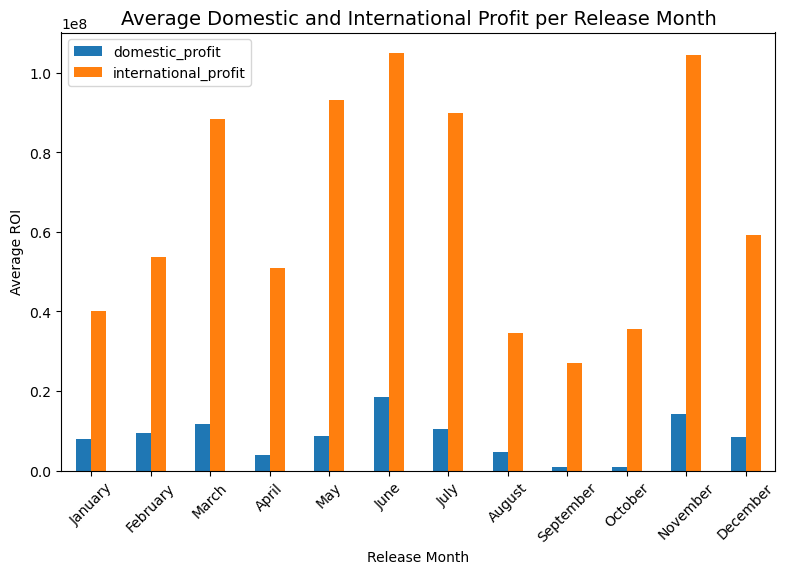

In [59]:
#Creating a bar chart comparing domestic and international ROI per Release Month
grouped_data.plot(kind='bar', figsize=(8, 6))
plt.title('Average Domestic and International Profit per Release Month', fontsize=14)
plt.xlabel('Release Month')
plt.ylabel('Average ROI')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout();

### ROI per Movie Production Studio

In [99]:
#Grouped df by studio and calculate average domestic and international ROI
grouped_studio = merged_studio.groupby('studio')[['domestic_roi', 'international_roi']].mean()
#Organized the df so we can get the the values in decreasing value by 'international ROI'
grouped_studio = grouped_studio.sort_values(by=['international_roi','domestic_roi'], ascending=False)
# Limit the df to the top 10 rows
grouped_studio_top10 = grouped_studio.nlargest(10, ['domestic_roi', 'international_roi'])

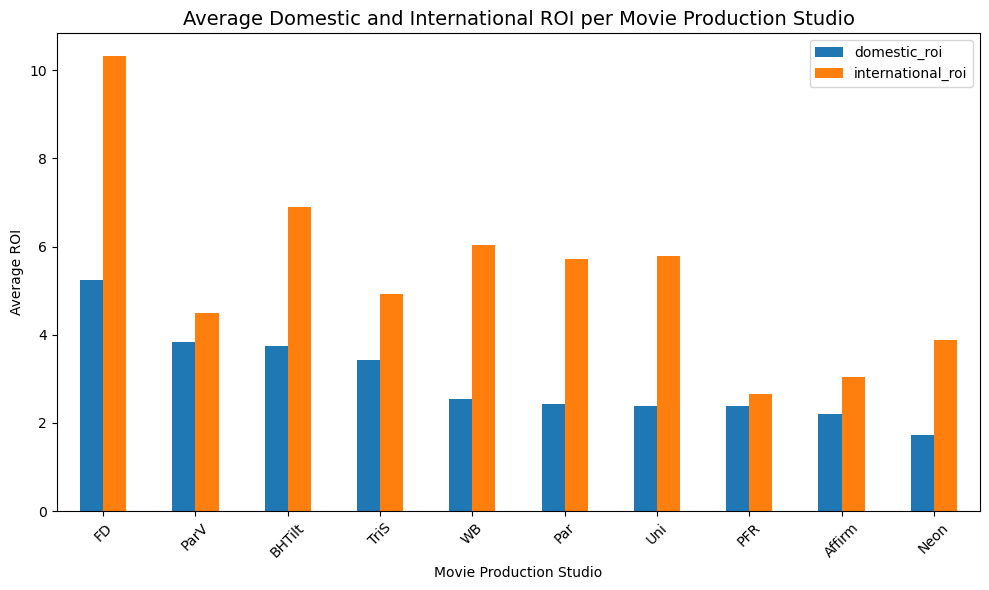

In [100]:
#Creating a bar chart comparing domestic and international ROI per Studio
grouped_studio_top10.plot(kind='bar', figsize=(10, 6))
plt.title('Average Domestic and International ROI per Movie Production Studio', fontsize=14)
plt.xlabel('Movie Production Studio')
plt.ylabel('Average ROI')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout();

## ROI per Movie Genres

In [62]:
#Grouped df by main_genre and calculate average ROI
#Sort information from the highest to lowest ROI

#Domestic ROI
average_domestic_roi = merged_movies.groupby('main_genre')['domestic_roi'].mean()
average_domestic_roi = average_domestic_roi.sort_values(ascending=False)

#International ROI
average_international_roi = merged_movies.groupby('main_genre')['international_roi'].mean()
average_international_roi= average_international_roi.sort_values(ascending=False)

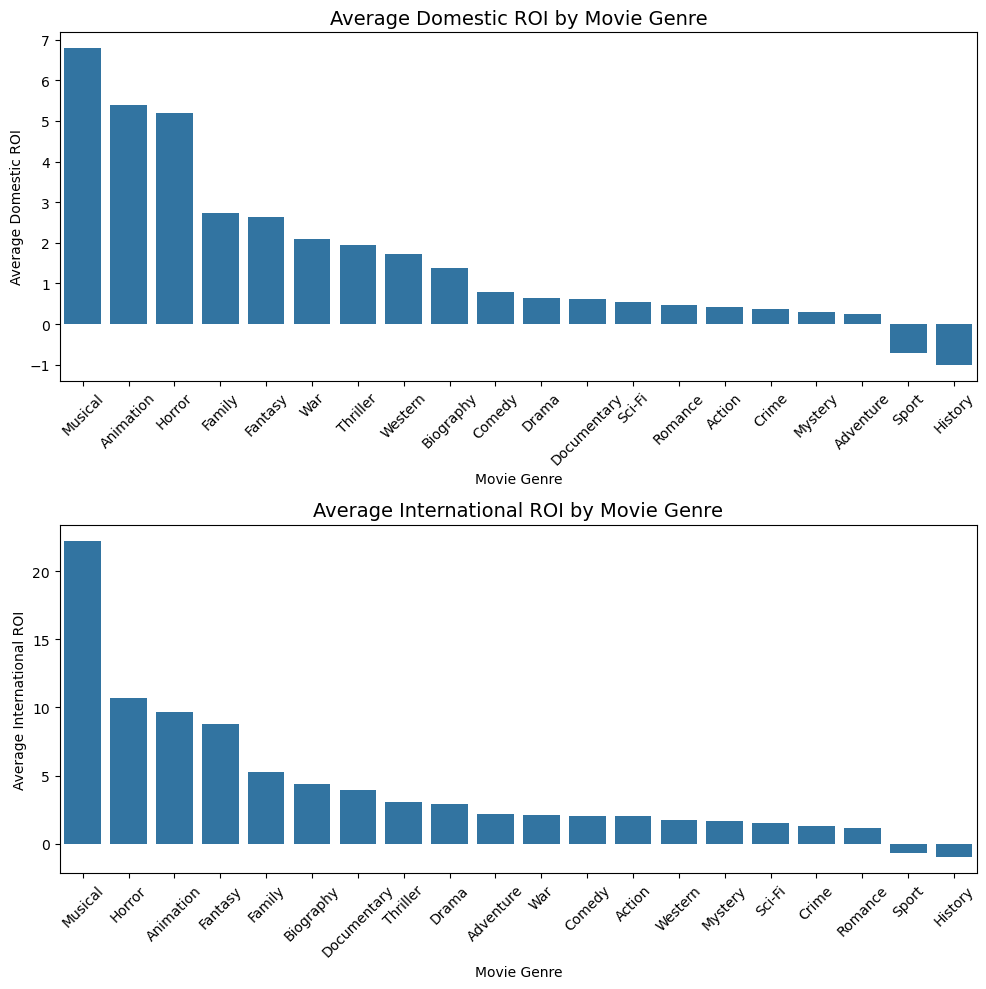

In [63]:
# Create a figure and subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plot the bar chart for Domestic ROI by Movie Genre
sns.barplot(x=average_domestic_roi.index, y=average_domestic_roi.values, ax=axes[0])

# Customize the Domestic ROI plot
axes[0].set_title('Average Domestic ROI by Movie Genre', fontsize=14)
axes[0].set_xlabel('Movie Genre')
axes[0].set_ylabel('Average Domestic ROI')
axes[0].tick_params(axis='x', rotation=45)

# Plot the bar chart for International ROI by Movie Genre
sns.barplot(x=average_international_roi.index, y=average_international_roi.values, ax=axes[1])

# Customize the International ROI plot
axes[1].set_title('Average International ROI by Movie Genre', fontsize=14)
axes[1].set_xlabel('Movie Genre')
axes[1].set_ylabel('Average International ROI')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to fit the labels
plt.tight_layout();

In [95]:
#Grouped df by main_genre and calculate average domestic and international ROI
#Sort information from the highest to lowest ROI

grouped_genre = merged_movies.groupby('main_genre')[['domestic_roi','international_roi']].mean()
grouped_genre = grouped_genre.sort_values(by=['international_roi','domestic_roi'], ascending=[False,False])

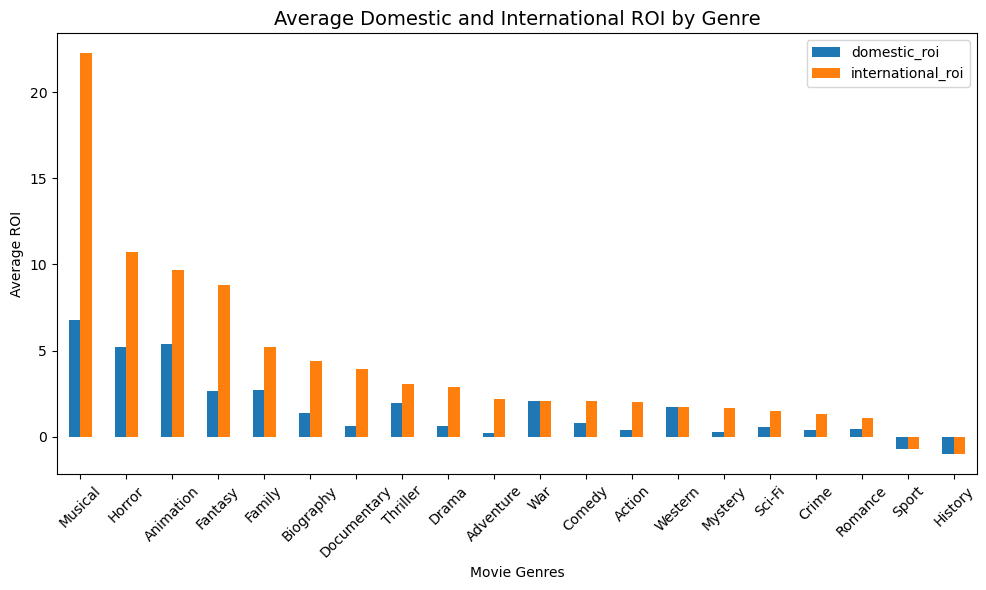

In [96]:
#Creating a bar chart comparing international and domestic average ROI per Movie Genre
grouped_genre.plot(kind='bar', figsize=(10, 6))
plt.title('Average Domestic and International ROI by Genre', fontsize=14)
plt.xlabel('Movie Genres')
plt.ylabel('Average ROI')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout();

### Popularity and ROI per Movie Genre

In [66]:
#Grouped df by main_genre and calculate average popularity
grouped_popularity = merged_popularity.groupby('main_genre')['popularity'].mean()
grouped_popularity = grouped_popularity.sort_values()

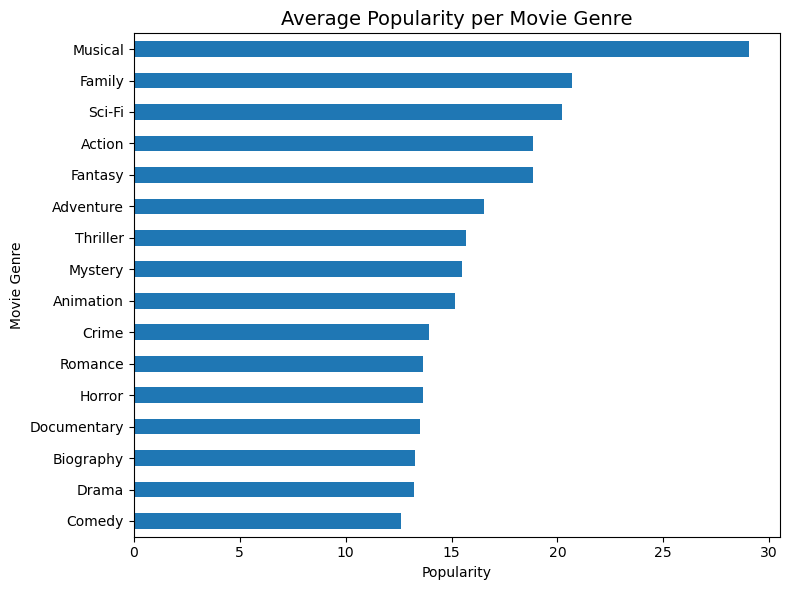

In [67]:
#Creating a horizontal bar chart for average popularity per main genre
grouped_popularity.plot(kind='barh', figsize=(8, 6))
plt.title('Average Popularity per Movie Genre', fontsize=14)
plt.xlabel('Popularity')
plt.ylabel('Movie Genre')
plt.tight_layout();

In [110]:
#Grouped df by main_genre and calculate average popularity and Domestic ROI
#Sort df by popularity
popularity_domestic = merged_popularity.groupby('main_genre')[['popularity', 'domestic_roi']].mean()
popularity_domestic = popularity_domestic.sort_values(by=['domestic_roi', 'popularity'], ascending=[False,False])

#Grouped df by main_genre and calculate average popularity and international ROI
#Sort df by popularity
popularity_international = merged_popularity.groupby('main_genre')[['popularity','international_roi']].mean()
popularity_international = popularity_international.sort_values(by=['international_roi','popularity'], ascending=[False,False])

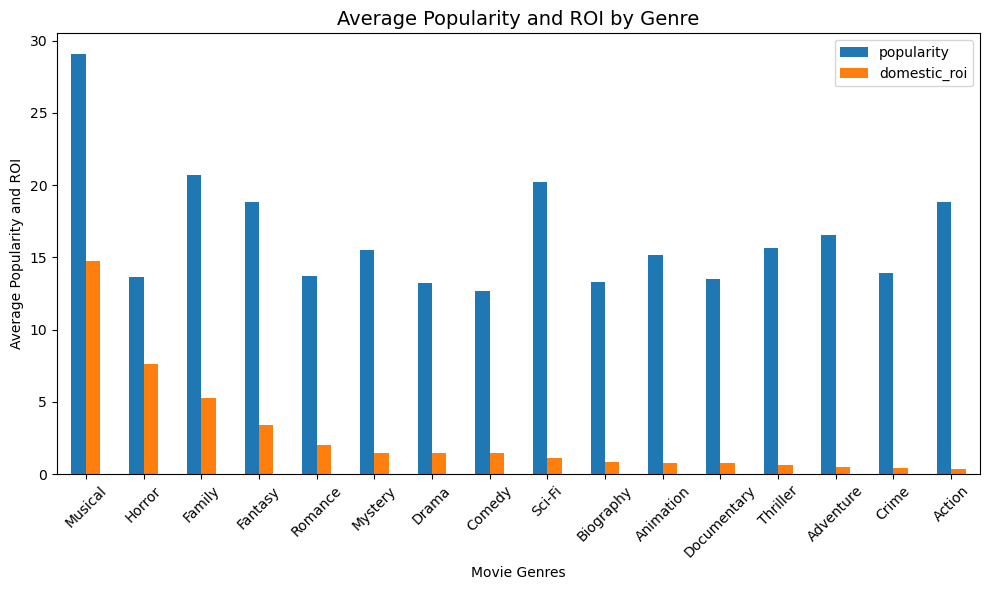

In [111]:
#Creating a bar chart comparing popularity and domestic ROI per Movie Genre
popularity_domestic.plot(kind='bar', figsize=(10, 6))
plt.title('Average Popularity and ROI by Genre', fontsize=14)
plt.xlabel('Movie Genres')
plt.ylabel('Average Popularity and ROI')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout();

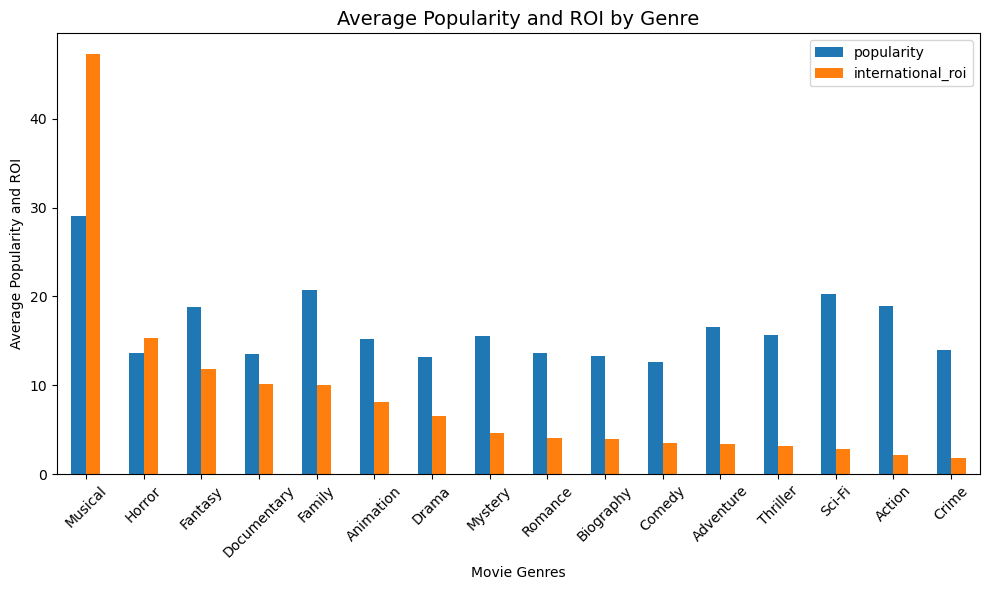

In [109]:
#Creating a bar chart comparing popularity and International ROI per Movie Genre
popularity_international.plot(kind='bar', figsize=(10, 6))
plt.title('Average Popularity and ROI by Genre', fontsize=14)
plt.xlabel('Movie Genres')
plt.ylabel('Average Popularity and ROI')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout();

Before making any deductions, understanding if there is correlation between Popularity with International and Domestic ROI

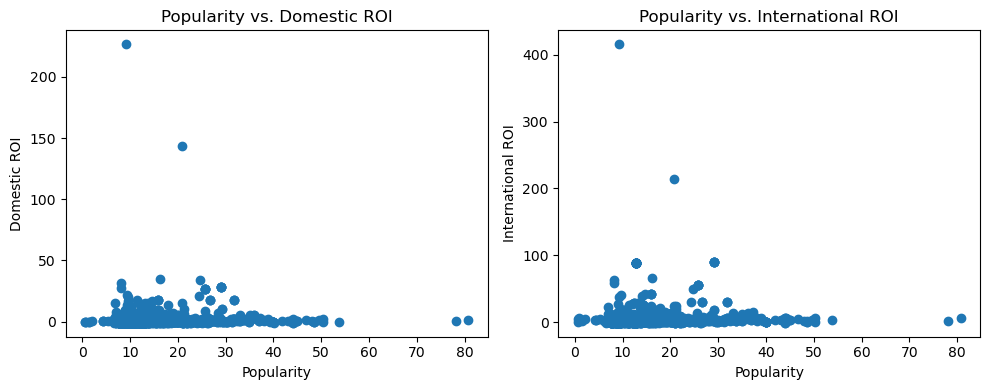

In [71]:
#Plotting a scatter grpah comparing Popularity vs domestic and internal ROI
# Create a figure and subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 

# Plot domestic ROI on the first subplot
axs[0].scatter(merged_popularity['popularity'], merged_popularity['domestic_roi'])
axs[0].set_title('Popularity vs. Domestic ROI')
axs[0].set_xlabel('Popularity')
axs[0].set_ylabel('Domestic ROI')

# Plot international ROI on the second subplot
axs[1].scatter(merged_popularity['popularity'], merged_popularity['international_roi'])
axs[1].set_title('Popularity vs. International ROI')
axs[1].set_xlabel('Popularity')
axs[1].set_ylabel('International ROI')

# Adjust layout to prevent overlapping elements
plt.tight_layout();


In [72]:
#Calculating correlation between popularity and domestic ROI
correlation = merged_popularity['popularity'].corr(merged_movies['domestic_roi'])
print("Correlation between popularity and Domestic ROI:", correlation)

#Calculating correlation between popularity and international ROI
correlation = merged_popularity['popularity'].corr(merged_movies['international_roi'])
print("Correlation between popularity and International ROI:", correlation)

Correlation between popularity and Domestic ROI: -0.03120935762701554
Correlation between popularity and International ROI: -0.028835336383473097


### ROI per movie director

In [124]:
#Grouped df by director and calculate average domestic and international ROI
grouped_directors = merged_directors.groupby('director_name')[['domestic_roi', 'international_roi']].mean()
#Organized the df so we can get the the values in decreasing value by 'international ROI'
grouped_directors = grouped_directors.sort_values(by=['international_roi','domestic_roi'], ascending=False)
# Limit the df to the top 15 rows
grouped_directors_top15 = grouped_directors.head(15)

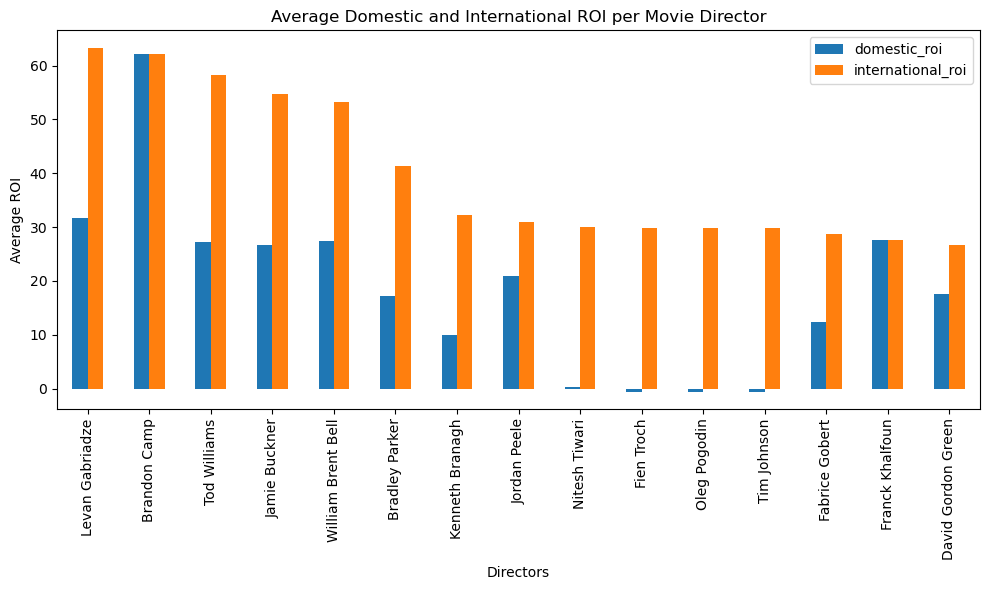

In [128]:
#Creating a bar chart comparing domestic and international ROI per director
grouped_directors_top15.plot(kind='bar', figsize=(10, 6))
plt.title('Average Domestic and International ROI per Movie Director')
plt.xlabel('Directors')
plt.ylabel('Average ROI')
plt.legend()
plt.tight_layout();

In [135]:
#Understadning main Genre for Top 3 Directors
director_names = ['Levan Gabriadze', 'Brandon Camp', 'Tod Williams', 'Jamie Buckner']
merged_directors[merged_directors['director_name'].isin(director_names)]

,movie,director_name,main_genre,domestic_roi,international_roi
257,Benji,Brandon Camp,Crime,62.119120,62.119120
1064,Paranormal Activity 2,Tod Williams,Horror,27.250969,58.170677
1449,Split,Jamie Buckner,Comedy,26.628317,54.792961
1672,Unfriended,Levan Gabriadze,Horror,31.789645,63.364198


Per the above information, I have a couple of takeaways:
- I will not count Brandon Camp, as the domestic and internatioal average ROI is the same which mean there is missing information for either domestic or international.
- The movie Split is not a 'Comedy' but a 'Horror' or 'Thriller'

In [127]:
#Understanding relationship between Directors with highest ROI vs Movie Genre
helper.filter_df_by_slection(merged_directors,'director_name',list(grouped_directors_top15.index))

main_genre
Horror       11
Drama        10
Adventure     4
Comedy        3
Crime         2
Action        2
Biography     1
Name: count, dtype: int64

### ROI per actors

In [136]:
#Grouped df by actor and calculate average domestic and international ROI
grouped_actors = merged_actors.groupby('actor_name')[['domestic_roi', 'international_roi']].mean()
#Organized the df so we can get the the values in decreasing value by 'international ROI'
grouped_actors = grouped_actors.sort_values(by=['international_roi','domestic_roi'], ascending=False)
# Limit the df to the top 15 rows
grouped_actors_top15 = grouped_actors.head(15)

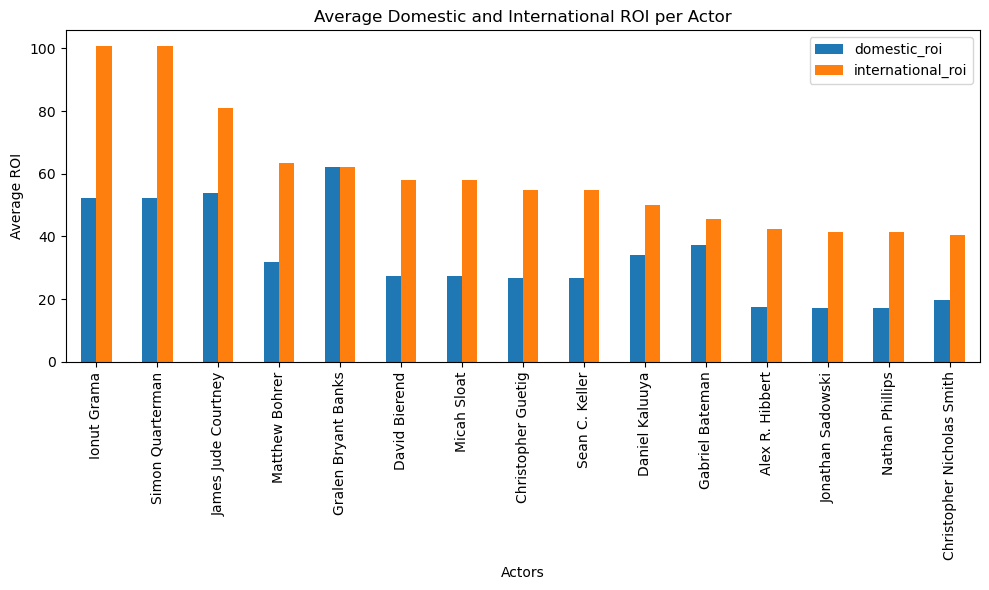

In [137]:
#Creating a bar chart comparing domestic and international ROI per actor
grouped_actors_top15.plot(kind='bar', figsize=(10, 6))
plt.title('Average Domestic and International ROI per Actor')
plt.xlabel('Actors')
plt.ylabel('Average ROI')
plt.legend()
plt.tight_layout();

In [139]:
#Understadning main Genre for Top 3 Actors
actor_names = ['Ionut Grama', 'Simon Quarterman', 'James Jude Courtney']
merged_actors[merged_actors['actor_name'].isin(actor_names)]

,movie,actor_name,main_genre,domestic_roi,international_roi
26,The Devil Inside,Simon Quarterman,Horror,52.262945,100.759490
27,The Devil Inside,Ionut Grama,Horror,52.262945,100.759490
1598,Halloween,James Jude Courtney,Horror,2.884610,4.167627
1599,Halloween,James Jude Courtney,Horror,14.934202,24.490067
1600,Halloween,James Jude Courtney,Horror,143.615385,214.384615


In [78]:
#Understanding relationship between Actors with highest ROI vs Movie Genre
helper.filter_df_by_slection(merged_actors,'actor_name',(grouped_actors_top15.index))

main_genre
Horror    12
Crime      2
Comedy     2
Drama      2
Name: count, dtype: int64

### ROI per actresses

In [141]:
#Grouped df by actress and calculate average domestic and international ROI
grouped_actresses = merged_actresses.groupby('actress_name')[['domestic_roi', 'international_roi']].mean()
#Organized the df so we can get the the values in decreasing value by 'international ROI'
grouped_actresses = grouped_actresses.sort_values(by=['international_roi','domestic_roi'], ascending=False)
# Limit the df to the top 15 rows
grouped_actresses_top15 = grouped_actresses.head(15)

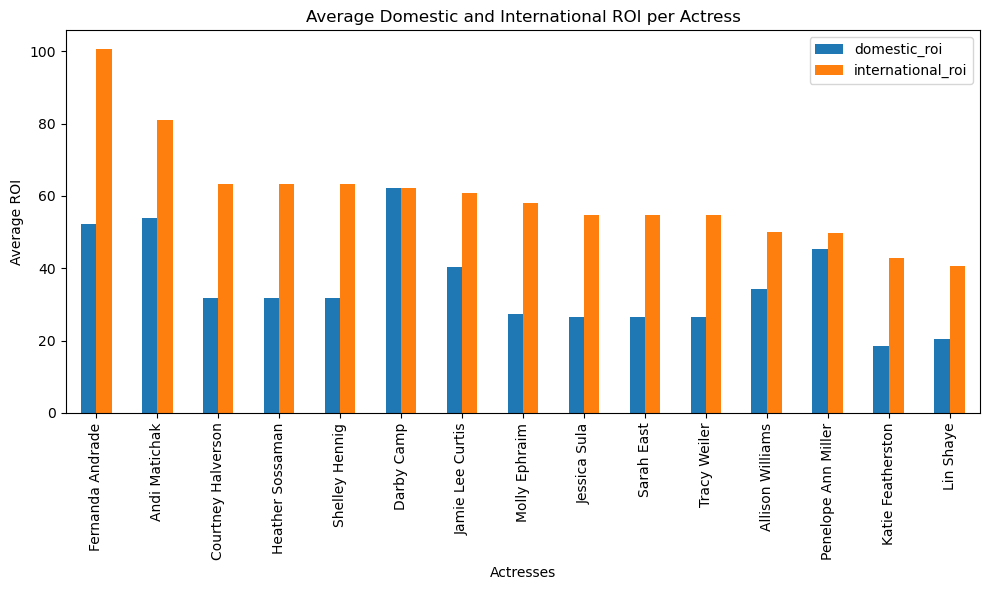

In [142]:
#Creating a bar chart comparing domestic and international ROI per actress
grouped_actresses_top15.plot(kind='bar', figsize=(10, 6))
plt.title('Average Domestic and International ROI per Actress')
plt.xlabel('Actresses')
plt.ylabel('Average ROI')
plt.legend()
plt.tight_layout();

In [146]:
#Understadning main Genre for Top 4 Actresses
actress_names = ['Fernanda Andrade', 'Andi Matichak', 'Courtney Halverson', 'Heather Sossaman']
merged_actresses[merged_actresses['actress_name'].isin(actress_names)]

,movie,actress_name,main_genre,domestic_roi,international_roi
14,The Devil Inside,Fernanda Andrade,Horror,52.262945,100.759490
939,Halloween,Andi Matichak,Horror,2.884610,4.167627
940,Halloween,Andi Matichak,Horror,14.934202,24.490067
941,Halloween,Andi Matichak,Horror,143.615385,214.384615
2355,Unfriended,Heather Sossaman,Horror,31.789645,63.364198
2356,Unfriended,Courtney Halverson,Horror,31.789645,63.364198


In [81]:
#Understanding relationship between Actors with highest ROI vs Movie Genre
helper.filter_df_by_slection(merged_actresses,'actress_name',list(grouped_actresses_top15.index))

main_genre
Horror       17
Comedy        3
Biography     2
Crime         1
Name: count, dtype: int64

### ROI per writers

In [82]:
#Grouped df by writer and calculate average domestic and international ROI
grouped_writers = merged_writers.groupby('writer_name')[['domestic_roi', 'international_roi']].mean()
#Organized the df so we can get the the values in decreasing value by 'international ROI'
grouped_writers = grouped_writers.sort_values(by=['international_roi','domestic_roi'], ascending=False)
# Limit the df to the top 15 rows
grouped_writers_top15 = grouped_writers.head(15)

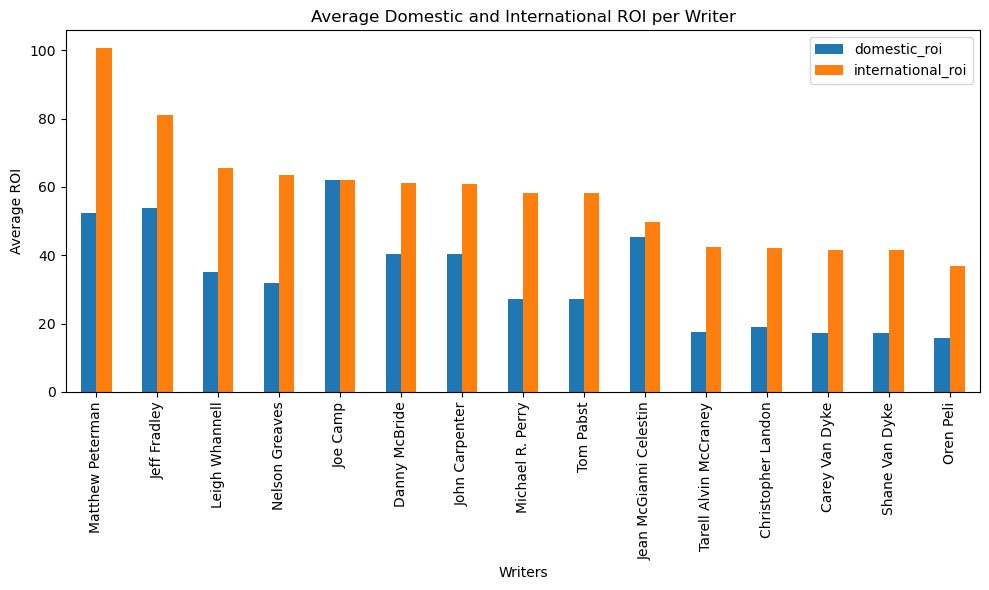

In [83]:
#Creating a bar chart comparing domestic and international ROI per writer
grouped_writers_top15.plot(kind='bar', figsize=(10, 6))
plt.title('Average Domestic and International ROI per Writer')
plt.xlabel('Writers')
plt.ylabel('Average ROI')
plt.legend()
plt.tight_layout();

In [147]:
#Understadning main Genre for Top 3 Writers
writer_names = ['Matthew Peterman', 'Jeff Fradley', 'Leigh Whannell']
merged_writers[merged_writers['writer_name'].isin(writer_names)]

,movie,writer_name,main_genre,domestic_roi,international_roi
15,The Devil Inside,Matthew Peterman,Horror,52.262945,100.759490
1128,Halloween,Jeff Fradley,Horror,2.884610,4.167627
1129,Halloween,Jeff Fradley,Horror,14.934202,24.490067
1130,Halloween,Jeff Fradley,Horror,143.615385,214.384615
1835,Insidious,Leigh Whannell,Horror,35.006100,65.580591


In [148]:
#Understanding relationship between Actors with highest ROI vs Movie Genre
helper.filter_df_by_slection(merged_writers,'writer_name',list(grouped_writers_top15.index))

main_genre
Horror       24
Action        2
Biography     2
Crime         1
Drama         1
Name: count, dtype: int64

# Conclusions

Based on the above analysis I will summarized by conclusions below:

***Movie Profit Per Release Month***

Based on the analysis, the key months to release a movie are ****June and November****. Based on the information available, the average profits are shown below:
- In June the average domestic profit is \$18.58\$M while the average international profit is \$104.87\$M.
  
- In November the average domestic profit is \$14.21\$M while the average international profit is \$104.49\$M.

***ROI per Movie Production Studio***

Based on our analysis, considering both a high average Domestic and International ROI to consider, the Movie Production studios to consider are the following:
- <a href="https://www.fd1.com/">FD Productions</a> with an average Domestic ROI of 5.24 and an average International ROI of 10.32. Based on further research, FD Productions specialized in a wide variety of content. When it comes to movies, they have successfully produced independent and full feature films of various genres such as drama, comedy, action and horror.
- <a href="https://www.blumhouse.com/films">BH Tilt division from Blumhouse</a> with an average Domestic ROI of 3.74 and an average International ROI of 6.89. Based on further information, Blumhouse is well know for their innovative movie distribution strategies by releasing movies in movie theaters, streaming platforms and through video on demand services. Blumhouse is also well-known for focusing on horror and thriller films, delivering disturbing movies and suspenful movies with a low budget.

***ROI per Movie Genre***

Based on our analysis, the key Movie Genres to focus on are the following:
- Musical with an average Domestic ROI of 6.79 and an average International ROI of 22.25.
- Horror with an average Domestic ROI of 5.19 and an average International ROI of 10.71.
- Animation with an average Domestic ROI of 5.40 and an average International ROI of 9.69.

***ROI vs Popularity per Movie Genre***

Based on the comparison of ROI and Popularity per Movie Genre, we got the following takeaways:
- Based on average Domestic ROI and Popularity, both Musical and Horror have the highest ratings.
- Based on average International ROI and Popularity, both Musical and Horror have the highest average ROI. However when it comes to popularity, Musical also has the highest score but horror does not but sits in the middle of the bar graph. Animation Genre has a higher than horror.

I run a correlation for both popularity and averafe Domestic ROI and well as popularity and average International ROI, with the respective results: -0.0312 and -0.0288. Interpreting the results we can conclude that the popularity of a movie doesn't strongly predict its financial success in the domestic or international market. Due to the very weak negative correlation for both calculations, we can conclude that popular movie can still have a low ROI, and a less popular movie can still have a high ROI. However, popularity is an impact factor to consider in the movie industry as it explains tastes and preferences of film audiences and the strategies developed by producers to direct and satisfy them. This is further explained in <a href="https://d-nb.info/1234464950/34#:~:text=Film%20popularity%20is%20an%20important,to%20direct%20and%20satisfy%20them.">this Measuring Film Popularity paper.</a>

***ROI per Director, Actor, Actress and Writer***

Based on the highest average Domestic and International ROI I was able to determine the best Directors, Actors, Actresses and Writers to partner with in order to produce a succesful movie:
- The Directors to partner with are Levan Gabriadze, Tod Williams and Jamie Brucker.
- The Actors to partner with are Ionut Grama, Simon Quarterman and James Jude Courtney.
- The Actresses to partner with are Fernanda Andrade, Andi Matichak, Courtney Halverson and Heather Sossaman.
- The Writers to partner with are Matthew Peterman, Jeff Fradley and Leigh Whannel.

Additionally, when assessing the combined number of movies of the top 15 Directors, Actors, Actresses and Writers with highest average Domestic and Internatioanal ROI I was able to determine that the most popular Movie Genre is Horror.

## Recommendations

Based on the above analysis my recommendations are the following:

1. ***Focus on Horror or related Movie Genres***
   
Through my analysis, Horror movies have consistently shown one of the highest ROI both Domestically and Internationally. Through the analysis, we have seen that Horror movies seemed to attrack a wide audience. Based on <a href="https://hbr.org/2021/10/the-psychology-behind-why-we-love-or-hate-horror#:~:text=For%20instance%2C%20watching%20a%20horror,parts%20of%20the%20human%20condition.">Harvard Business Review</a> I have also confirm that popularity and engagement of users with Horror movies are because these provide a safe space to experience the thrill of fear, triggering a physiological response that can be exciting and stimulating, while knowing that the danger is not real.

Furthermore, Horror Movies is one of the genres that is normally associated with a low budget according to the <a href="https://americanfilmmarket.com/what-the-data-says-producing-low-budget-horror-films/">American Film Market</a> so making sure to take steps to produce an outstanding Horror movie with a low budget by partering with a studio such as <a href="https://www.blumhouse.com/films">Blumhouse </a> will allow our company to achieve a high ROI while keeping our risks to the minimum.

2. ***Invest in partnering with High ROI Talent (Directors, Writers, Actors and Actresses) in the Horror Movie Genre***

Partnering with the proven talent in the Horror Movie Genre will allow us to produce a movie that will be better suited for our audienced which will result in higher popularity, engagement and ultimately returns. Based on the above analysis we can target some of the key talent within the Genre such as:Levan Gabriadze, Tod Williams and Jamie Brucker for Directors; Ionut Grama, Simon Quarterman and James Jude Courtney for Actors; Fernanda Andrade, Andi Matichak, Courtney Halverson and Heather Sossaman for Actresses and Matthew Peterman, Jeff Fradley and Leigh Whannel for Writers.
   
3. ***Focus on releasing movies on key months such as a June and November***

Based on our analysis, our first movie shoudl be release in June or November as historically these are the months where movies have usually delivered the greatest average Domestic and International Profits.

## Limitations

The key limitations of this analysis are the following:

- To get to conclusions and merged the data to get more insights, I have to cut down the dataset quite a lot. For example IMDB 146,144 lines of movie information but The Numbers dataset with production cost and domestic/international gross revenue information only had 5,782 lines.
- Movies can sometimes be categorized within multiple genres and in this analysis to simplify categorization we only assign one genre per movie. However due to the number of lines we cannot always confirm that the movie genre so we could potential not be analyzing the movie on their right genre.
- Multiple factors influence the success of a movie and we are only focusing on ROI and profit for a couple of variables such as genre, studios, directors, writers, actors, actresses, release month. While I'm analyzing the above, there could be a lot other factors that will affect the ROI and/or success of a movie.

## Next steps

1. Further investigate the considerations for producing a Horror Movie.
2. Define if we want to focus on single movie or work produce a franchise.
3. Investigate how do you attrack and retain the right talent that will help the success of your movie.